# NOTEBOOK 6: CLASSIFICATION - Neural Network
### Team 3
- Anjali Sebastian
- Yesha Sharma
- Rupansh Phutela

### What this Notebook does?
After Data selection, cleaning, pre-processing, EDA and Regression Analysis, Clustering and Naive Bayes Classification we will now look at how we can perform other types of classfication on our data. Our data has target varibale y = Diabetes (Yes or No) we will try to classify the data to see the performance of different classifiers. In this Notebook we are trying various **Neural Network** Classification Models.

 - Normalization of entire dataset due to varying ranges of different attributes
 - Feature Importances - Identify Best Features
 - Use Principle Component Analysis to reduce dimensionality of the best selected features
 - Multiple Neural Network models that have different number of layer, activation functions and regularization parameters.
 - Analysis of the Best Neural in terms of metrics, confusion matrix, classification report and ROC Curve 
 - Conclusion
 - References


## 1. Import Packages and Setup

In [1]:
# you need   Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [3]:
import os
import pandas as pd   
import numpy as np    
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
##############################################

In [4]:
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering_kmeans"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# method to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## 2. Utility Functions

In [5]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00','#00AAFF','#000000','#FF00AA','#2ca02c', '#d62728','#9467bd','#8c564b','#e377c2']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    plt.show()

In [6]:
# a function to plot a bar graph of important features
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    #plt.figure(figsize=(15,4))
    plt.figure(figsize=(8,8))
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

In [7]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score


def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test,y_pred)
        recall_class1 = recall_score(y_test, y_pred, average=None)[1]
        
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)
        title = title + "\nF1 score = {:.2f}, Recall Class 1 = {:.2f}".format(f1,recall_class1)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test,y_pred)
        recall_class1 = recall_score(y_test, y_pred, average=None)[1]
    
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)
        title = title + "\nF1 score = {:.2f},  Recall Class 1 = {:.2f}".format(f1,recall_class1)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()

In [8]:
# Show confusion matrix
def plot_confusion_matrix(confusion_mat, cln):
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.gray)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(cln)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 3. Read Data and Display

In [9]:
diabetes = pd.read_csv('./diabetes.csv')

In [10]:
diabetes.head()

,Unnamed: 0,Diabetes,BMI,State,HighBP,HighChol,CholCheck,FruitConsume,VegetableConsume,Smoker,...,NoDoctorDueToCost,PhysicalActivity,GeneralHealth,PhysicalHealth,MentalHealth,DifficultyWalking,Gender,Age,Education,Income
0,0,0.0,28.17,AL,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,3.0,15.0,0.0,1.0,0.0,13.0,3.0,3.0
1,1,0.0,18.54,AL,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,2.0,10.0,0.0,0.0,0.0,11.0,5.0,5.0
2,2,1.0,31.62,AL,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,3.0,0.0,30.0,1.0,0.0,10.0,6.0,7.0
3,6,1.0,32.98,AL,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,4.0,30.0,0.0,1.0,1.0,11.0,6.0,7.0
4,9,1.0,16.65,AL,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,20.0,0.0,1.0,0.0,11.0,2.0,3.0


In [11]:
#set datatypes of columns to boolean or categorical as appropriate
make_bool_int = ['Diabetes','HighBP','HighChol','CholCheck',\
             'FruitConsume','VegetableConsume','Smoker','HeavyDrinker','Stroke','HeartDisease',\
             'Healthcare','NoDoctorDueToCost','PhysicalActivity','DifficultyWalking','Gender']
make_categorical_int = ['GeneralHealth','Age','Education','Income']

In [12]:
#drop the extra index column in datafram
diabetes=diabetes.drop(['Unnamed: 0'], axis=1)

#drop the state column in dataframe since it will not be used in the dataframe
diabetes=diabetes.drop(['State'], axis=1)

In [13]:
diabetes.head()

,Diabetes,BMI,HighBP,HighChol,CholCheck,FruitConsume,VegetableConsume,Smoker,HeavyDrinker,Stroke,...,NoDoctorDueToCost,PhysicalActivity,GeneralHealth,PhysicalHealth,MentalHealth,DifficultyWalking,Gender,Age,Education,Income
0,0.0,28.17,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,3.0,15.0,0.0,1.0,0.0,13.0,3.0,3.0
1,0.0,18.54,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,2.0,10.0,0.0,0.0,0.0,11.0,5.0,5.0
2,1.0,31.62,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,3.0,0.0,30.0,1.0,0.0,10.0,6.0,7.0
3,1.0,32.98,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,4.0,30.0,0.0,1.0,1.0,11.0,6.0,7.0
4,1.0,16.65,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,20.0,0.0,1.0,0.0,11.0,2.0,3.0


In [14]:
# deep copy before next stage
df = diabetes.copy(deep = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243317 entries, 0 to 243316
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Diabetes           243317 non-null  float64
 1   BMI                243317 non-null  float64
 2   HighBP             243317 non-null  float64
 3   HighChol           243317 non-null  float64
 4   CholCheck          243317 non-null  float64
 5   FruitConsume       243317 non-null  float64
 6   VegetableConsume   243317 non-null  float64
 7   Smoker             243317 non-null  float64
 8   HeavyDrinker       243317 non-null  float64
 9   Stroke             243317 non-null  float64
 10  HeartDisease       243317 non-null  float64
 11  Healthcare         243317 non-null  float64
 12  NoDoctorDueToCost  243317 non-null  float64
 13  PhysicalActivity   243317 non-null  float64
 14  GeneralHealth      243317 non-null  float64
 15  PhysicalHealth     243317 non-null  float64
 16  Me

In [16]:
df.shape

(243317, 22)

## 4. Normalization and Simple Vizualization

In [17]:
X_columns = ['BMI', 'HighBP', 'HighChol', 'CholCheck', 'FruitConsume',
       'VegetableConsume', 'Smoker', 'HeavyDrinker', 'Stroke', 'HeartDisease',
       'Healthcare', 'NoDoctorDueToCost', 'PhysicalActivity', 'GeneralHealth',
       'PhysicalHealth', 'MentalHealth', 'DifficultyWalking', 'Gender', 'Age',
       'Education', 'Income']

Text(0.5, 1.0, 'Vizualizing the full data (attributes BMI, HighBP). Not Normalized')

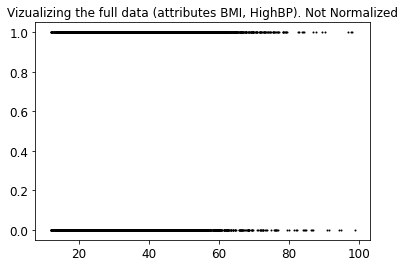

In [18]:
# separating the target column y = Diabetes before classification
# for complete dataset
X_df = df[X_columns].values
y_df = df[['Diabetes']]
plot_data(X_df)
plt.title("Vizualizing the full data (attributes BMI, HighBP). Not Normalized")

Text(0.5, 1.0, 'Vizualizing the full data (attributes BMI, HighBP). Normalized')

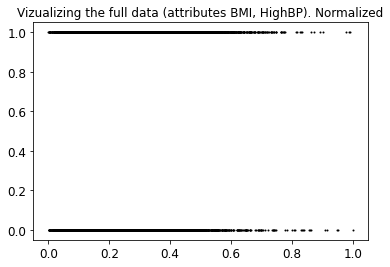

In [19]:
# Using minmax scaler for normalization
from sklearn.preprocessing import MinMaxScaler

# normalization full dataset
X_normalized = MinMaxScaler().fit(X_df).transform(X_df)
df_normalized = pd.DataFrame(X_normalized, columns=X_columns )
plot_data(X_normalized)
plt.title("Vizualizing the full data (attributes BMI, HighBP). Normalized")

Note: The data pairs are as follows:
- Full Data
    1. X_df (pandas) with y_df(pandas) : not normalized full data set
    2. X_normalized (numpy) with y_df(pandas) : normalized full X in numpy (easy for clustering)
    3. df_normalized (pandas) with y_df(pandas) : normalized X in pandas format (easy for tracking feature names)
    
- For all our classification we will use only the normalized versions of the dataset.
- We will first pick the best features flowing which we will use PCA to reduce dataset to 2 features

##  5. Feature Importances - With Decision Tree Classifier
- We are using Decision Tree Classifier to find which features are more important  to see which features are having the highestimpact on our target.
- We will only be using normalized data. Since it will put all features in similar range.  
- We will be using the full dataset as is . We will also we using a balanced version of the dataset using undersampling technique to see if there is any change in the key features.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [21]:
X = X_normalized
y_df['Diabetes']=y_df['Diabetes'].astype('int')
y = y_df.to_numpy()

In [22]:
# A simple training (1 training)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.30)

#### Using Full Dataset As Is

Accuracy of DT classifier on training set: 1.00
Accuracy of DT classifier on test set: 0.79


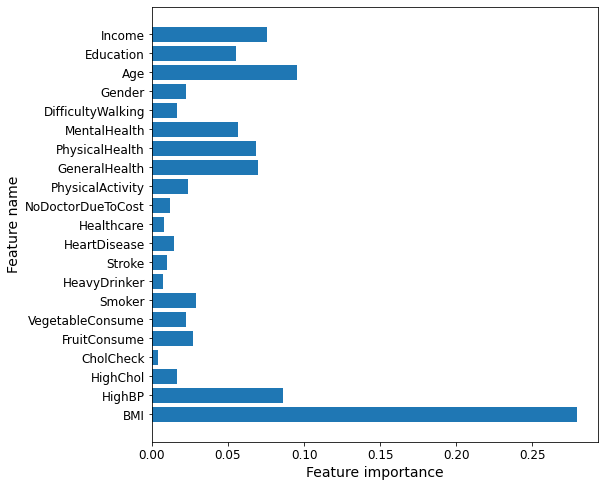

Feature importances: [0.27931751 0.08635461 0.01666336 0.00396084 0.02698384 0.02236237
 0.02883552 0.00744351 0.00987176 0.01420467 0.0082121  0.01204351
 0.02342647 0.06937859 0.06842486 0.05683353 0.01673057 0.02241037
 0.09529659 0.05551182 0.0757336 ]


In [23]:
clf = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Accuracy of DT classifier on training set: {:.2f}'.format(train_score))
print('Accuracy of DT classifier on test set: {:.2f}'.format(test_score))

#plt.figure(figsize=(12,12), dpi=60)

# import features (call the function above)
plot_feature_importances(clf, df_normalized.columns)

plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

In [24]:
clf.score(X_test, y_test)

0.7932900432900433

In [25]:
y_pred = clf.predict(X_test)

#  confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat

array([[54468,  8045],
       [ 7044,  3439]], dtype=int64)

In [26]:
# Print classification report
target_names = ['Class 0', 'Class 1']

result_metrics = classification_report(y_test, y_pred, target_names=target_names)
print(result_metrics)

              precision    recall  f1-score   support

     Class 0       0.89      0.87      0.88     62513
     Class 1       0.30      0.33      0.31     10483

    accuracy                           0.79     72996
   macro avg       0.59      0.60      0.60     72996
weighted avg       0.80      0.79      0.80     72996



#### Doing with a Balanced Dataset 
- using random undersampler only on the training part  

In [27]:
# import RandomUndersampler
from imblearn.under_sampling import RandomUnderSampler

In [28]:
X_train.shape

(170321, 21)

In [29]:
under = RandomUnderSampler(sampling_strategy='auto')
X_train, y_train = under.fit_resample(X_train, y_train)

In [30]:
X_train.shape

(49632, 21)

In [31]:
unique, counts = np.unique(y_train, return_counts=True)
print ( np.asarray((unique, counts)).T)

[[    0 24816]
 [    1 24816]]


Accuracy of DT classifier on training set: 1.00
Accuracy of DT classifier on test set: 0.66


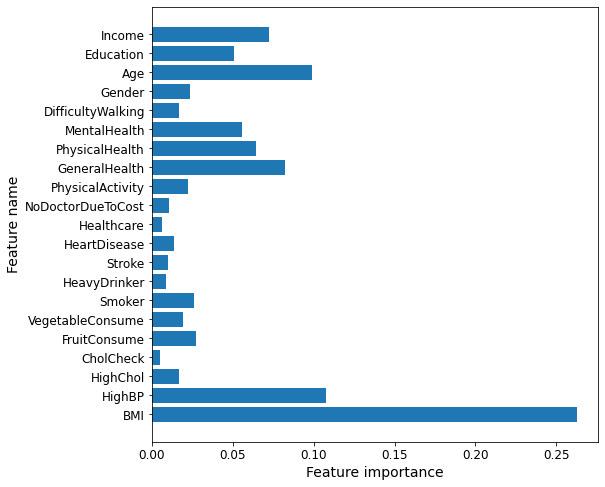

Feature importances: [0.26291005 0.10754319 0.01688605 0.00499179 0.02712826 0.01928236
 0.02616177 0.00840229 0.00992798 0.01337396 0.0062639  0.01041017
 0.02246018 0.0820788  0.06436261 0.05540956 0.01649228 0.02356799
 0.09920803 0.05057206 0.0725667 ]


In [32]:
clf = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)

train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Accuracy of DT classifier on training set: {:.2f}'.format(train_score))
print('Accuracy of DT classifier on test set: {:.2f}'.format(test_score))

#plt.figure(figsize=(12,12), dpi=60)

# import features (call the function above)
plot_feature_importances(clf, df_normalized.columns)

plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))

In [33]:
clf.score(X_test, y_test)

0.6602553564578881

In [34]:
y_pred = clf.predict(X_test)

#  confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred)
confusion_mat

array([[41328, 21185],
       [ 3615,  6868]], dtype=int64)

In [35]:
# Print classification report
target_names = ['Class 0', 'Class 1']

result_metrics = classification_report(y_test, y_pred, target_names=target_names)
print(result_metrics)

              precision    recall  f1-score   support

     Class 0       0.92      0.66      0.77     62513
     Class 1       0.24      0.66      0.36     10483

    accuracy                           0.66     72996
   macro avg       0.58      0.66      0.56     72996
weighted avg       0.82      0.66      0.71     72996



Note: Looking at at the feature importance we can see that the bar plots for both the original dataset and the balanced data set are having similar patterns. We see that the following 8 features are very important  -  BMI, HighBP, General Health, Physical Health, Mental Health, Age , Education and Income.     

In [36]:
# Create a list of important features
important_features = ['BMI','HighBP','GeneralHealth','PhysicalHealth','MentalHealth','Age','Education','Income']

## 5. Principle Component Analysis
- Using the only the most important features dicovered from the decision tree model we reduce the dimensionality to 2 using Principal Component Analysis 

In [37]:
df_normalized.head()

,BMI,HighBP,HighChol,CholCheck,FruitConsume,VegetableConsume,Smoker,HeavyDrinker,Stroke,HeartDisease,...,NoDoctorDueToCost,PhysicalActivity,GeneralHealth,PhysicalHealth,MentalHealth,DifficultyWalking,Gender,Age,Education,Income
0,0.186505,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.50,0.500000,0.0,1.0,0.0,1.000000,0.4,0.285714
1,0.075433,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.25,0.333333,0.0,0.0,0.0,0.833333,0.8,0.571429
2,0.226298,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.50,0.000000,1.0,1.0,0.0,0.750000,1.0,0.857143
3,0.241984,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.75,1.000000,0.0,1.0,1.0,0.833333,1.0,0.857143
4,0.053633,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.666667,0.0,1.0,0.0,0.833333,0.2,0.285714


In [38]:
# Choose True if we are selecting only 8 top features for doing PCA else it will take entire data set
select_features = True

if(select_features==True):
    df_best_features = df_normalized[important_features]
else:
    df_best_features = df_normalized
df_best_features.head()

,BMI,HighBP,GeneralHealth,PhysicalHealth,MentalHealth,Age,Education,Income
0,0.186505,1.0,0.50,0.500000,0.0,1.000000,0.4,0.285714
1,0.075433,0.0,0.25,0.333333,0.0,0.833333,0.8,0.571429
2,0.226298,1.0,0.50,0.000000,1.0,0.750000,1.0,0.857143
3,0.241984,0.0,0.75,1.000000,0.0,0.833333,1.0,0.857143
4,0.053633,0.0,0.00,0.666667,0.0,0.833333,0.2,0.285714


In [39]:
# Dimesionality reduction to 2
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
pca_model.fit(df_best_features) # fit the model
X_normalized_pca = pca_model.transform(df_best_features)
X_normalized_pca

array([[ 0.8143773 ,  0.21944804],
       [-0.1775784 ,  0.39799483],
       [ 0.57868681, -0.00386865],
       ...,
       [-0.3079835 ,  0.39221926],
       [-0.47663154,  0.34781812],
       [-0.51515748, -0.06059107]])

In [40]:
# numpy 
X_normalized_pca.shape

(243317, 2)

In [41]:
# panda it 
df_X_normalized_pca = pd.DataFrame(X_normalized_pca, columns=['Feature1','Feature2'] )
df_X_normalized_pca.head()

,Feature1,Feature2
0,0.814377,0.219448
1,-0.177578,0.397995
2,0.578687,-0.003869
3,-0.225108,0.374260
4,0.051858,0.924369


Note: We have reduced our datasets dimensionality to 2 features which have just been named feature1 and feature2. Going ahead we will be using these two synthetic features to perform our classification.

## 6. Neural Networks
- Neural Network  is very computationaly intensive so we will take only a part of the dataset to run the classification on  (around 10,000) 
- For Neural Neworks we will try different X variables and classify the diabetics/non-diabetics.

In [42]:
# attach back the labels before sampling
df_normalized_pca = pd.concat([df_X_normalized_pca.reset_index(drop=True), y_df.reset_index(drop=True)], axis= 1)
df_normalized_pca.head()

,Feature1,Feature2,Diabetes
0,0.814377,0.219448,0
1,-0.177578,0.397995,0
2,0.578687,-0.003869,1
3,-0.225108,0.374260,1
4,0.051858,0.924369,1


In [43]:
# Selecting a random sample for the data set
#sampling a random number of values since neural net classification of all 0.2 million datapoints is too slow
# option 10000 , 50000 etc.
number_of_samples = 10000
sample_normalized_pca = df_normalized_pca.sample(number_of_samples, random_state=42)

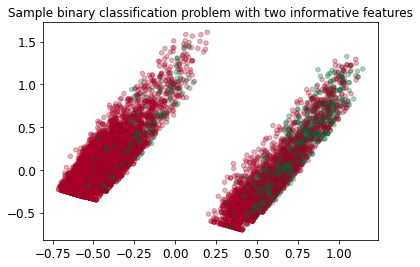

In [44]:
# plotting the 2 attributes of PCA
plt.figure()
plt.title('Sample binary classification problem with two informative features')

#Plotting just 5000 points to not clutter the scatter plot
plt.scatter(sample_normalized_pca.iloc[:, 0], sample_normalized_pca.iloc[:, 1], alpha = 0.3,cmap=plt.cm.RdYlGn,marker= 'o', s=20, c=sample_normalized_pca.loc[:,'Diabetes'])
plt.show()

In [45]:
# set up the Data 
X = sample_normalized_pca.iloc[:,[0,1]].to_numpy()
y = sample_normalized_pca.iloc[:,[2]].to_numpy()
print(X.shape)

(10000, 2)


In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

# undersampling only on the Training sets 
under = RandomUnderSampler(sampling_strategy='auto')
X_train, y_train = under.fit_resample(X_train, y_train)
print(X_train.shape)

(2168, 2)


### MODEL 1: 2 Layers with Default Activation (Relu) No Regularization
- We are using normalized data that was transformed by PCA to 2 features
- We will use under sampling technique since we are more interested in positive cases
- We only undersample the training sets because the model needs to perform with naturally imbalanced data (ie less positive diabetes cases) we leave the test sets as they are.
- Try different number of units in the layers

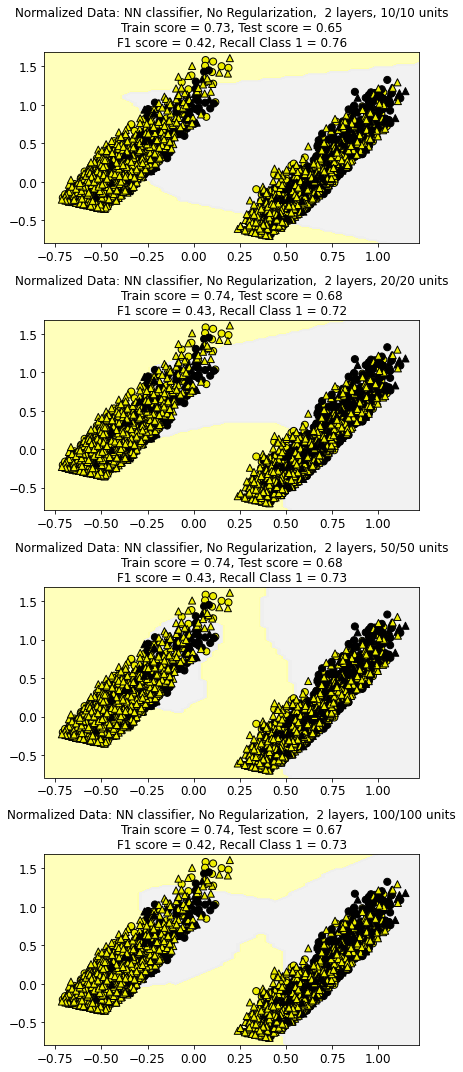

In [47]:
fig, subaxes = plt.subplots(4, 1, figsize=(6, 15))
for units, axis in zip([10,20,50,100], subaxes):
    # training the data
    nnclf = MLPClassifier(hidden_layer_sizes = [units,units],
                          solver='lbfgs', random_state=42).fit(X_train,y_train)
    title = 'Normalized Data: NN classifier, No Regularization,  2 layers, {:.0f}/{:.0f} units'.format(units,units)
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,X_test, y_test, title, axis)
    plt.tight_layout()

Notes: Best models look like two layers with either 50 units or 100 units. We need to apply regularization to see if this trend continues

### MODEL 3: 2 Layers with Default Activation (Relu) with Different Regularization Levels

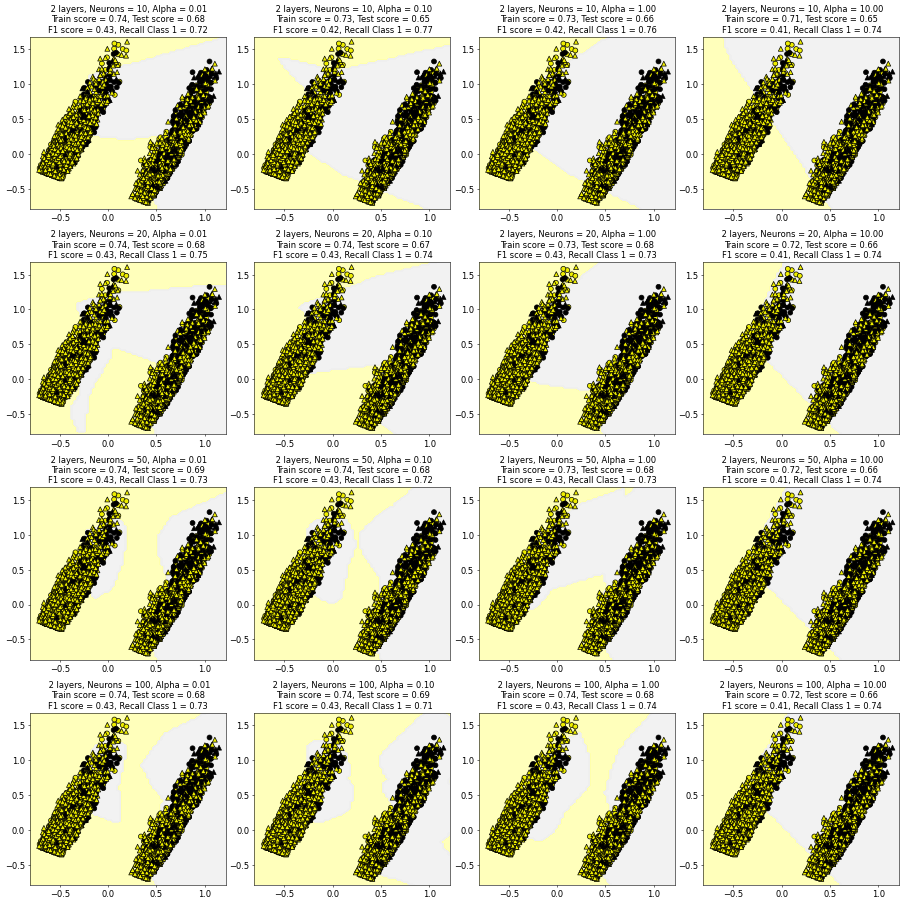

In [48]:
fig, subaxes = plt.subplots(4, 4, figsize=(18, 18), dpi=50)

for this_unit, this_axis in zip([10, 20,50,100], subaxes):  
    for this_alpha, subplot in zip([0.01, 0.1, 1, 10], this_axis):
    
        title = ' 2 layers, Neurons = {:.0f}, Alpha = {:.2f}'.format(this_unit, this_alpha)
        nnclf = MLPClassifier(hidden_layer_sizes = [this_unit,this_unit], alpha = this_alpha, solver='lbfgs', random_state=42).fit(X_train,y_train)
        plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,X_test, y_test, title, subplot)
        
        
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


Note: Multiple models have very similar performance. WE are displaying the F1 score and Recall for class 1 to further differentiate. But there all the models here are very comparable so the least complex model would be best. 

### MODEL 4: 4 , 5 and 6 Layers with Default Activation (Relu) with Different Regularization Levels
- Do adding more layers help?

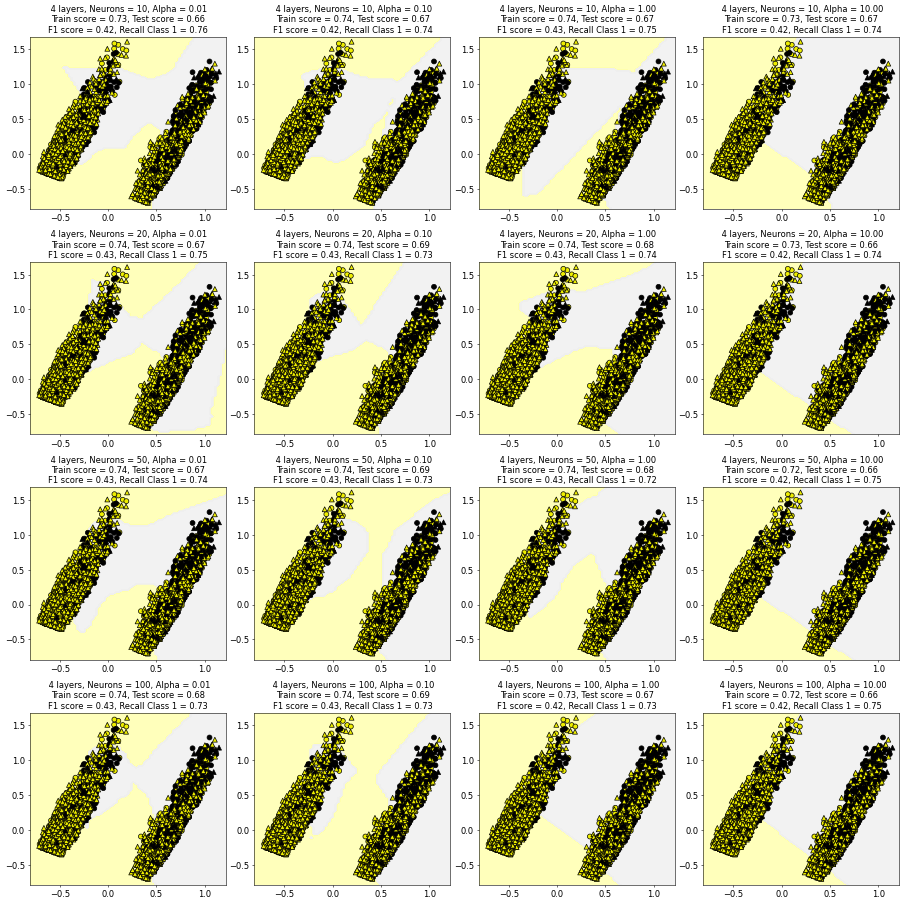

In [49]:
fig, subaxes = plt.subplots(4, 4, figsize=(18, 18), dpi=50)

for this_unit, this_axis in zip([10, 20,50,100], subaxes):  
    for this_alpha, subplot in zip([0.01, 0.1, 1, 10], this_axis):
    
        title = ' 4 layers, Neurons = {:.0f}, Alpha = {:.2f}'.format(this_unit, this_alpha)
        nnclf = MLPClassifier(hidden_layer_sizes = [this_unit,this_unit,this_unit,this_unit], alpha = this_alpha, solver='lbfgs', random_state=42).fit(X_train,y_train)
        plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,X_test, y_test, title, subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


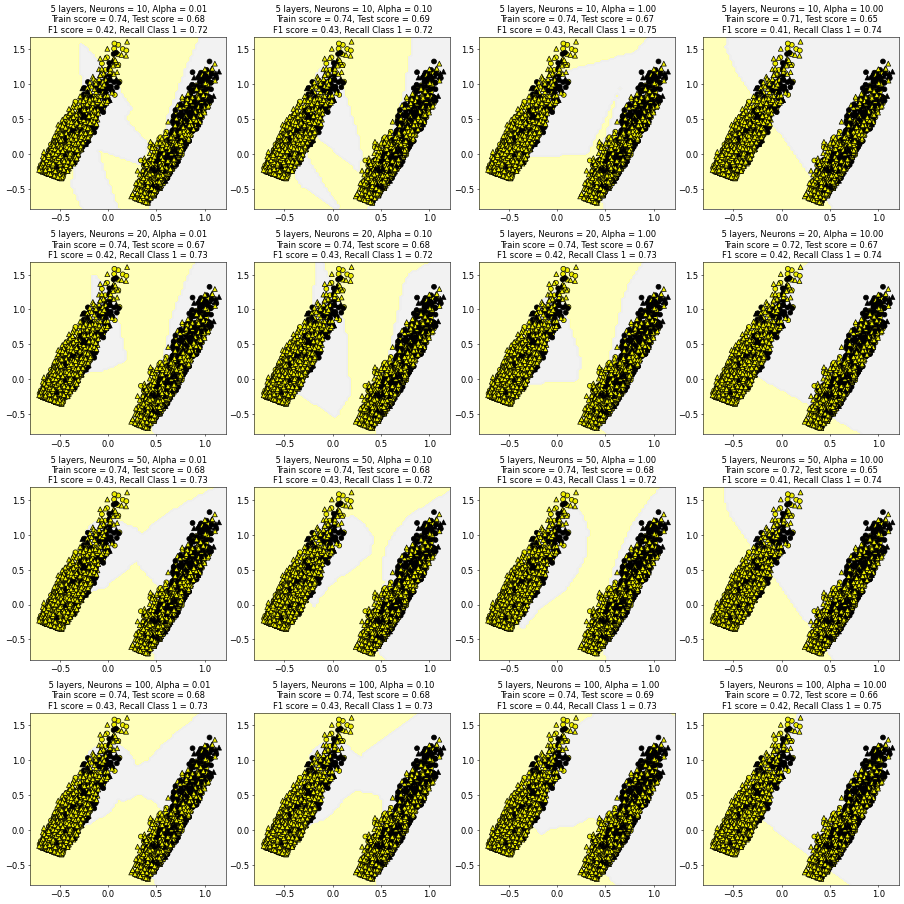

In [50]:
fig, subaxes = plt.subplots(4, 4, figsize=(18, 18), dpi=50)

for this_unit, this_axis in zip([10, 20,50,100], subaxes):  
    for this_alpha, subplot in zip([0.01, 0.1, 1, 10], this_axis):
    
        title = ' 5 layers, Neurons = {:.0f}, Alpha = {:.2f}'.format(this_unit, this_alpha)
        nnclf = MLPClassifier(hidden_layer_sizes = [this_unit,this_unit,this_unit,this_unit,this_unit], alpha = this_alpha, solver='lbfgs', random_state=42).fit(X_train,y_train)
        plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,X_test, y_test, title, subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

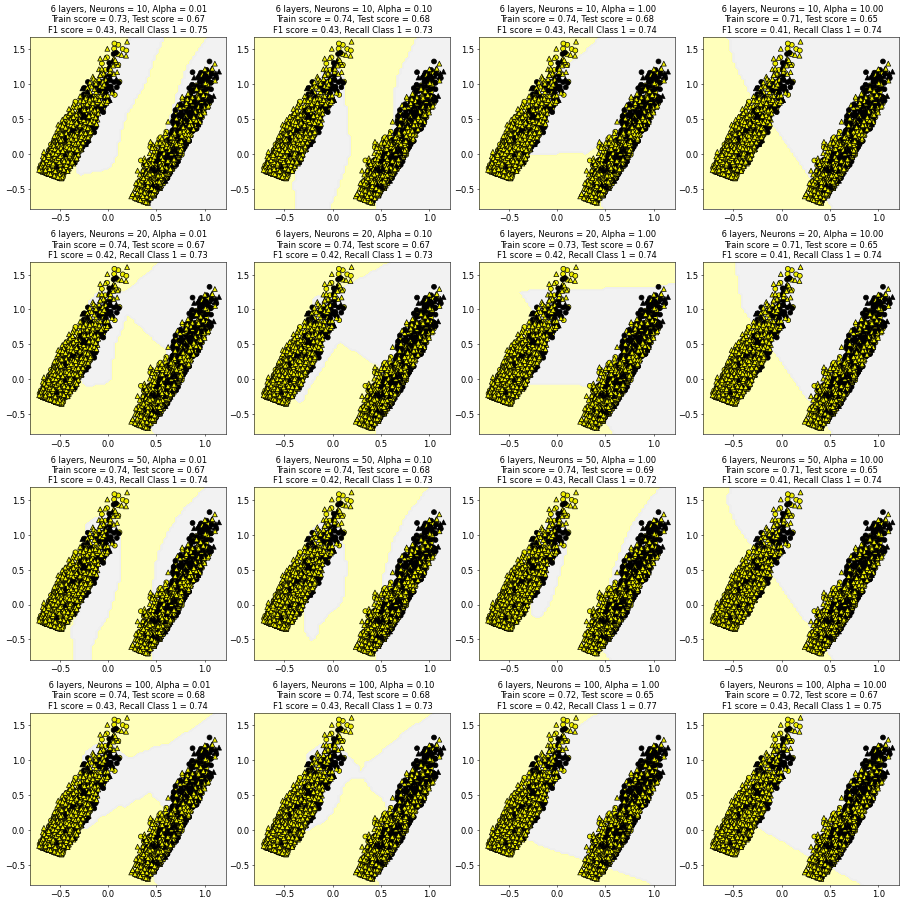

In [51]:
fig, subaxes = plt.subplots(4, 4, figsize=(18, 18), dpi=50)

for this_unit, this_axis in zip([10, 20,50,100], subaxes):  
    for this_alpha, subplot in zip([0.01, 0.1, 1, 10], this_axis):
    
        title = ' 6 layers, Neurons = {:.0f}, Alpha = {:.2f}'.format(this_unit, this_alpha)
        nnclf = MLPClassifier(hidden_layer_sizes = [this_unit,this_unit,this_unit,this_unit,this_unit,this_unit], alpha = this_alpha, solver='lbfgs', random_state=42).fit(X_train,y_train)
        plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,X_test, y_test, title, subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

Note: Yes adding some more layers is helps upto a point. Best Model appears to be 5 layers of 100 neurons each with Alpha of 1. However increasing the layers to 6 layer is worse than 5. Therefore, we can see that the test scores are falling most likely due to overfit.  The best model is at 5 layer of 100 neurons with alpha = 1 . The train score = 0.74 and test score = 0.69. F1 =0.44


### MODEL 5: Changing Activation Function with Different Regularization Levels
- Are there better activation functions?
- We will use a 5 layer NN (100/100/100/100/100)
- alpha = 0.1 1

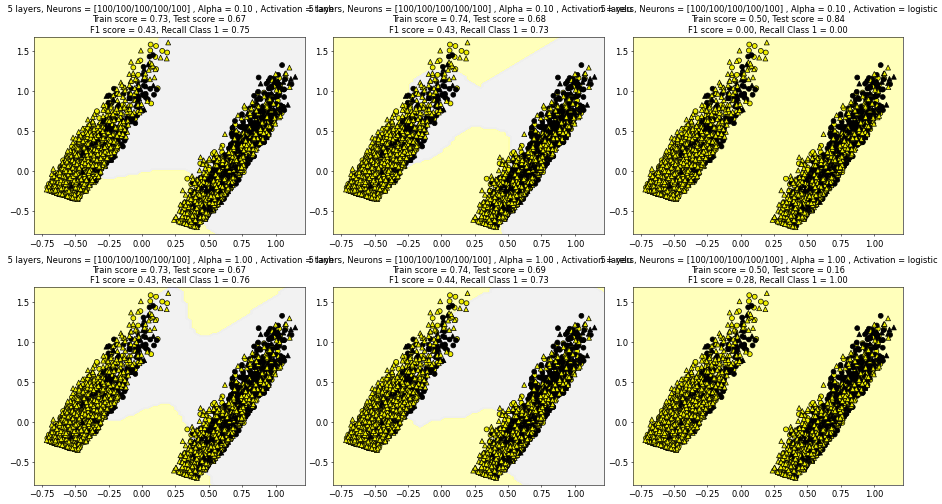

In [52]:
fig, subaxes = plt.subplots(2, 3, figsize=(18, 10), dpi=50)

for this_alpha, this_axis in zip([0.1,1], subaxes):  
    for this_activation, subplot in zip(['tanh', 'relu', 'logistic'], this_axis):
    
        title = ' 5 layers, Neurons = [100/100/100/100/100] , Alpha = {:.2f} , Activation = {}'.format(this_alpha,this_activation)
        nnclf = MLPClassifier(hidden_layer_sizes = [100,100,100,100,100], alpha = this_alpha, solver='lbfgs', random_state=42, activation = this_activation).fit(X_train,y_train)
        plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,X_test, y_test, title, subplot)
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

Note: Looking at all the activation functions the relu activation function sems to be performing the best. The best model is :5 layers of 100 neurons, activation function = relu, alpha =1 

### MODEL 6: Best Model - 5 layers of 100 neurons, activation function = relu, alpha =1 
- Note we continue to use normalized, dimension reduced feature . We have takne a small sample of the total data as Neural network is very computation intensive
- Vizualize the Model
- Metrics: Score , Confusion Matrix, Classification Report
- ROC and AUC curve

In [53]:
nn_best = MLPClassifier(hidden_layer_sizes = [100,100,100,100,100], alpha = 1, solver='lbfgs', random_state=42, activation = 'relu').fit(X_train,y_train)

#clf_best = SVC(kernel='rbf', max_iter=10000, gamma=5, C=15, probability =True , random_state=42).fit(X_train, y_train)


y_pred = nn_best.predict(X_test)

result_metrics = classification_report(y_test, y_pred)
print('Neural Network results\n', result_metrics)

Neural Network results
               precision    recall  f1-score   support

           0       0.93      0.68      0.79      2090
           1       0.31      0.73      0.44       410

    accuracy                           0.69      2500
   macro avg       0.62      0.71      0.61      2500
weighted avg       0.83      0.69      0.73      2500



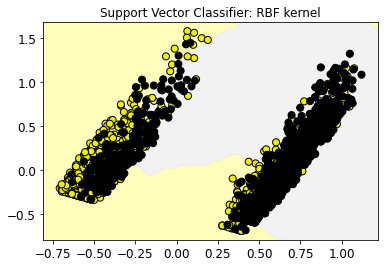

In [54]:
# Plot the classifier
plot_class_regions_for_classifier(nn_best.fit(X_train, y_train),
                                 X_train, y_train, None, None,
                                 'Support Vector Classifier: RBF kernel')

In [55]:
#Score
print(" Score for the SVM Model = ",nn_best.score(X_test, y_test))

# Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred)
print('\n Confusion Matrix: \n')
print(confusion_mat)

# Print classification report
target_names = ['Class 0', 'Class 1']
result_metrics = classification_report(y_test, y_pred, target_names=target_names)
print('\n Classification Report: \n')
print(result_metrics)

 Score for the SVM Model =  0.6892

 Confusion Matrix: 

[[1423  667]
 [ 110  300]]

 Classification Report: 

              precision    recall  f1-score   support

     Class 0       0.93      0.68      0.79      2090
     Class 1       0.31      0.73      0.44       410

    accuracy                           0.69      2500
   macro avg       0.62      0.71      0.61      2500
weighted avg       0.83      0.69      0.73      2500



Accuracy (AUC) =  0.7630073520830902


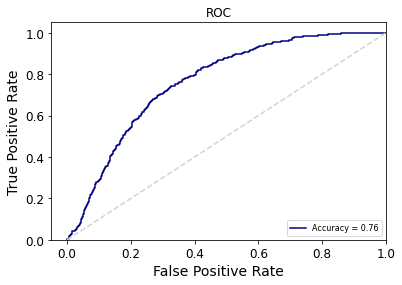

In [56]:
from sklearn.metrics import roc_curve, auc
y_score = nn_best.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)
print('Accuracy (AUC) = ', roc_auc)

count = 1

# Get different color each graph line
colorSet = ['navy', 'greenyellow', 'deepskyblue', 'darkviolet', 'crimson', 
            'darkslategray', 'indigo', 'brown', 'orange', 'palevioletred', 'mediumseagreen',
            'k', 'darkgoldenrod', 'g', 'midnightblue', 'c', 'y', 'r', 'b', 'm', 'lawngreen'
            'mediumturquoise', 'lime', 'teal', 'drive', 'sienna', 'sandybrown']
color = colorSet[count-1]

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, c=color, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Conclusion

- After selecting the most important features using the decision tree classifier (8 features out of 21). We carried out PCA and reduced the dimesions to two dimensions, This is similar to the analysis carried out in the Naive Bayes classifier sheet done prior.     
- Neural Networks are computationally expensive and we used a sample of 10,000 from the whole dataset (0.24 million) to train and test the model.
- The best neural network model has 5 layers with 100 neurons in each layer. Regularization was applied with alpha = 1. The RELU activation function was best among the three activation functions we tried
- Our Dataset is significantly imbalanced with positive class "Diabetes = Yes" is the minority. We are interested in catching positive cases. The classification reports show that Recall for class1 =  0.73 which is good but the precision is very low at 0.31. The model tends to generate many false positives.
- We found the result of the SVM classifier to be slightly better than the neural network models. This is detailed in the following sheet.

# REFERENCES 

https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet

https://mclguide.readthedocs.io/en/latest/sklearn/clusterdim.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

https://www.discoverbits.in/371/sklearn-attributeerror-predict_proba-available-probability

https://www.kaggle.com/residentmario/undersampling-and-oversampling-imbalanced-data


Material from Machine Learning Course, Seattle University  

Material from Introduction to Data Science, Seattle University  

# --END--
## NEXT NOTEBOOK -> project_part_4_Classification_SVM (Support Vector Machines)